In [1]:
import numpy as np 
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

In [2]:
#Cargamos los datos
events = pd.read_csv('C:\\Users\\dev\\repos\\fiuba\\tp1_anlisis_exploratorio\\events.csv', low_memory = False)
#Cabecera
events.head(1)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#descarto las que no me interesan
events.drop(columns=['channel','condition','storage','color','campaign_source','search_engine','url','staticpage','skus','search_term','device_type','browser_version','operating_system_version','screen_resolution','new_vs_returning'],inplace=True)
#convierto los tipos
events.event = events.event.astype('category')
events.model = events.model.astype('category')
events.city = events.city.astype('category')
events.region = events.region.astype('category')
events.country = events.country.astype('category')

In [4]:
#pongo de index al datetime y agrego columnas para segmentar el tiempo
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')
events.set_index(pd.DatetimeIndex(events.timestamp),inplace=True)
events.drop(columns='timestamp',inplace=True)
events['date'] = events.index.date
events['year'] = events.index.year
events['month'] = events.index.month
events['day'] = events.index.day
events['hour'] = events.index.hour
events['minute'] = events.index.minute
events['week'] = events.index.weekofyear
events['weekday'] = events.index.weekday # monday = 0, tuesday = 1...
events.sort_index(ascending=True,inplace=True)
events.head(1)

,event,person,sku,model,city,region,country,date,year,month,day,hour,minute,week,weekday
timestamp,,,,,,,,,,,,,,,
2018-01-01 07:32:26,ad campaign hit,9250d410,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018,1,1,7,32,1,0


In [44]:
def plot_heatmap(data,title='Titulo',xlabel='Leyenda X',ylabel='Leyenda Y'):
    plt.figure(figsize = (18,9))
    ax = sns.heatmap(data,linewidth = 3, cmap = 'Greens',robust=True)
    ax.set_title(title,Fontsize = 20)
    ax.set_ylabel(xlabel,Fontsize = 18)
    ax.set_xlabel(ylabel,fontsize = 18)

In [6]:
#todos los eventos, usuarios únicos, mes determinado
def heatmap_unique_users_between_dates(desde='2018-01-01 00:00:00',hasta='2018-07-01 00:00:00',title='Cantidad de usuarios únicos por hora y día del mes'):
    filtro = events[(events.index > desde)]
    filtro = filtro[(filtro.index < hasta)]
    per_date_total = filtro.groupby(['day','hour']).agg({'person':'nunique'}).unstack()
    per_date_total.columns = per_date_total.columns.droplevel(0)
    per_date_total.fillna(value=0,inplace=True)
    per_date_total = per_date_total.astype(dtype='int64')
    unique_users = per_date_total.transpose()
    unique_users.sort_index(ascending=False,inplace=True)
    plot_heatmap(unique_users,title,'Hora del Día','Día del mes')

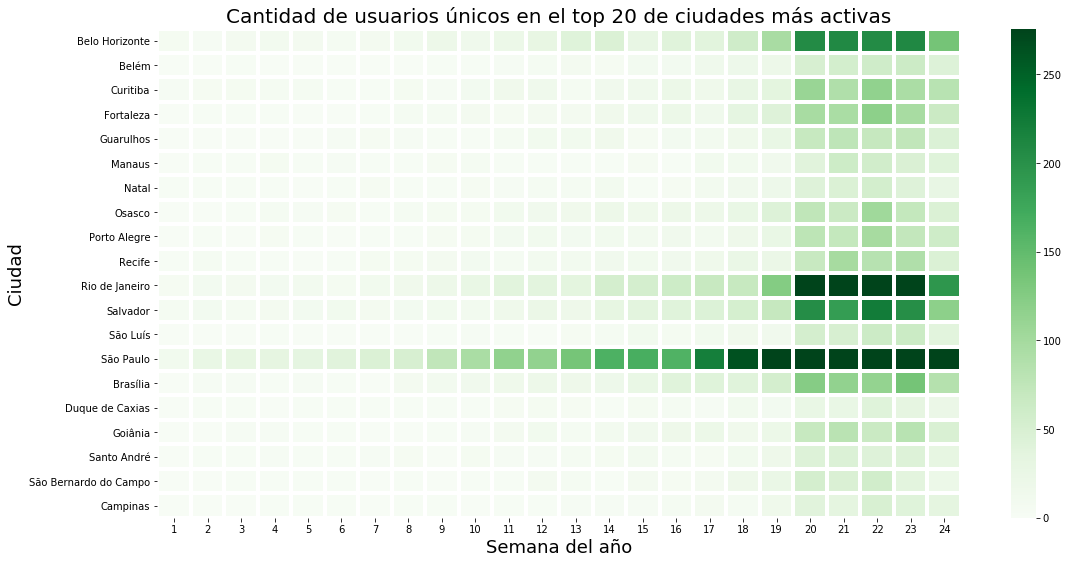

In [45]:
#cuento usuarios unicos por dia agrupados por ciudad
per_city_total = events.groupby(['city']).agg({'person':'nunique'}).unstack()
top_cities = per_city_total.nlargest(21)
top_cities = top_cities.reset_index()
top_cities.index = top_cities['city']
top_cities.drop(columns=['level_0','city'],inplace=True)
top_cities.columns = ['unique_users']
top_cities.drop('Unknown',inplace=True)
top_cities = top_cities.index.get_values()

filtered_events = events.loc[events.city.isin(top_cities)]

per_week_city = filtered_events.groupby(['week','city']).agg({'person':'nunique'}).unstack()
per_week_city.fillna(value=0,inplace=True)
per_week_city = per_week_city.astype(dtype='int64')
per_week_city.columns = per_week_city.columns.droplevel(0)
per_week_city = per_week_city.transpose()
plot_heatmap(per_week_city,'Cantidad de usuarios únicos en el top 20 de ciudades más activas','Ciudad','Semana del año')

(revisar el parámetro robust del heatmap)
A partir de este heatmap podríamos inferir que en San Pablo se adelantó el fuerte aumento de la cantidad de usuarios de la semana 19.

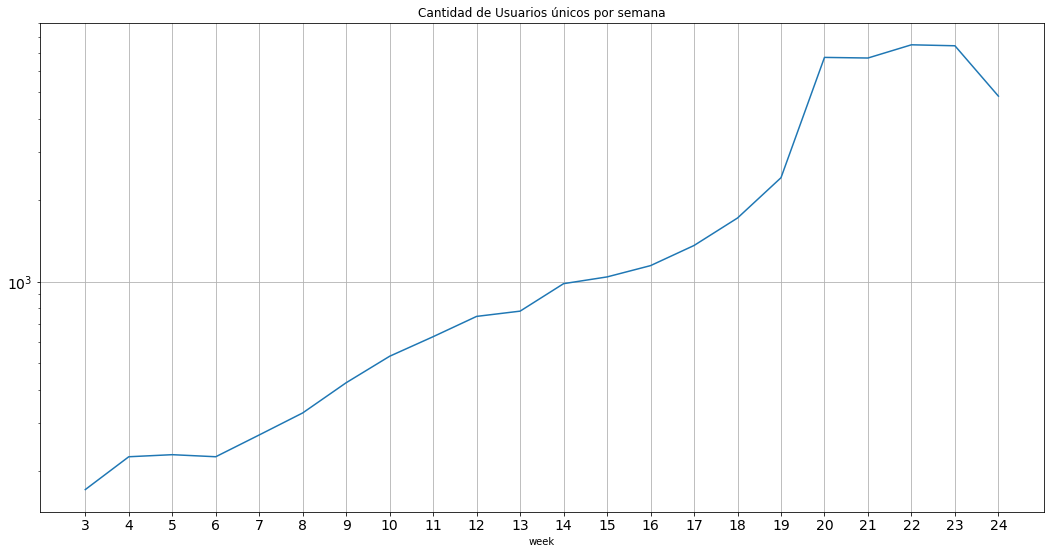

In [63]:
per_week_total_unique = events.groupby(['week']).agg({'person':'nunique'}).unstack()
per_week_total_unique.index = per_week_total_unique.index.droplevel(0)
logy = True
graph = per_week_total_unique.plot(logy=logy,figsize=(18,9),grid=True,title='Cantidad de Usuarios únicos por semana',fontsize=14,xticks=per_week_total_unique.index)

A partir del gráfico anterior, podemos determinar que durante la semana 19 (mayo) el tráfico en el sitio aumentó estrepitosamente.
Al graficar con escala logarítmica notamos que este crecimiento abrupto se detiene en la semana 22 y llega en la semana 24 a los mismos niveles que hubiera tenido si continuaba con la misma pendiente de crecimiento (exponencial) que tenìa hasta el punto de quiebre de la semana 19.
Cabría analizar la raíz de este fenómeno y ver sus resultados distinguiendo por categorías (otro notebook).